# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Preprocessing and Image Display

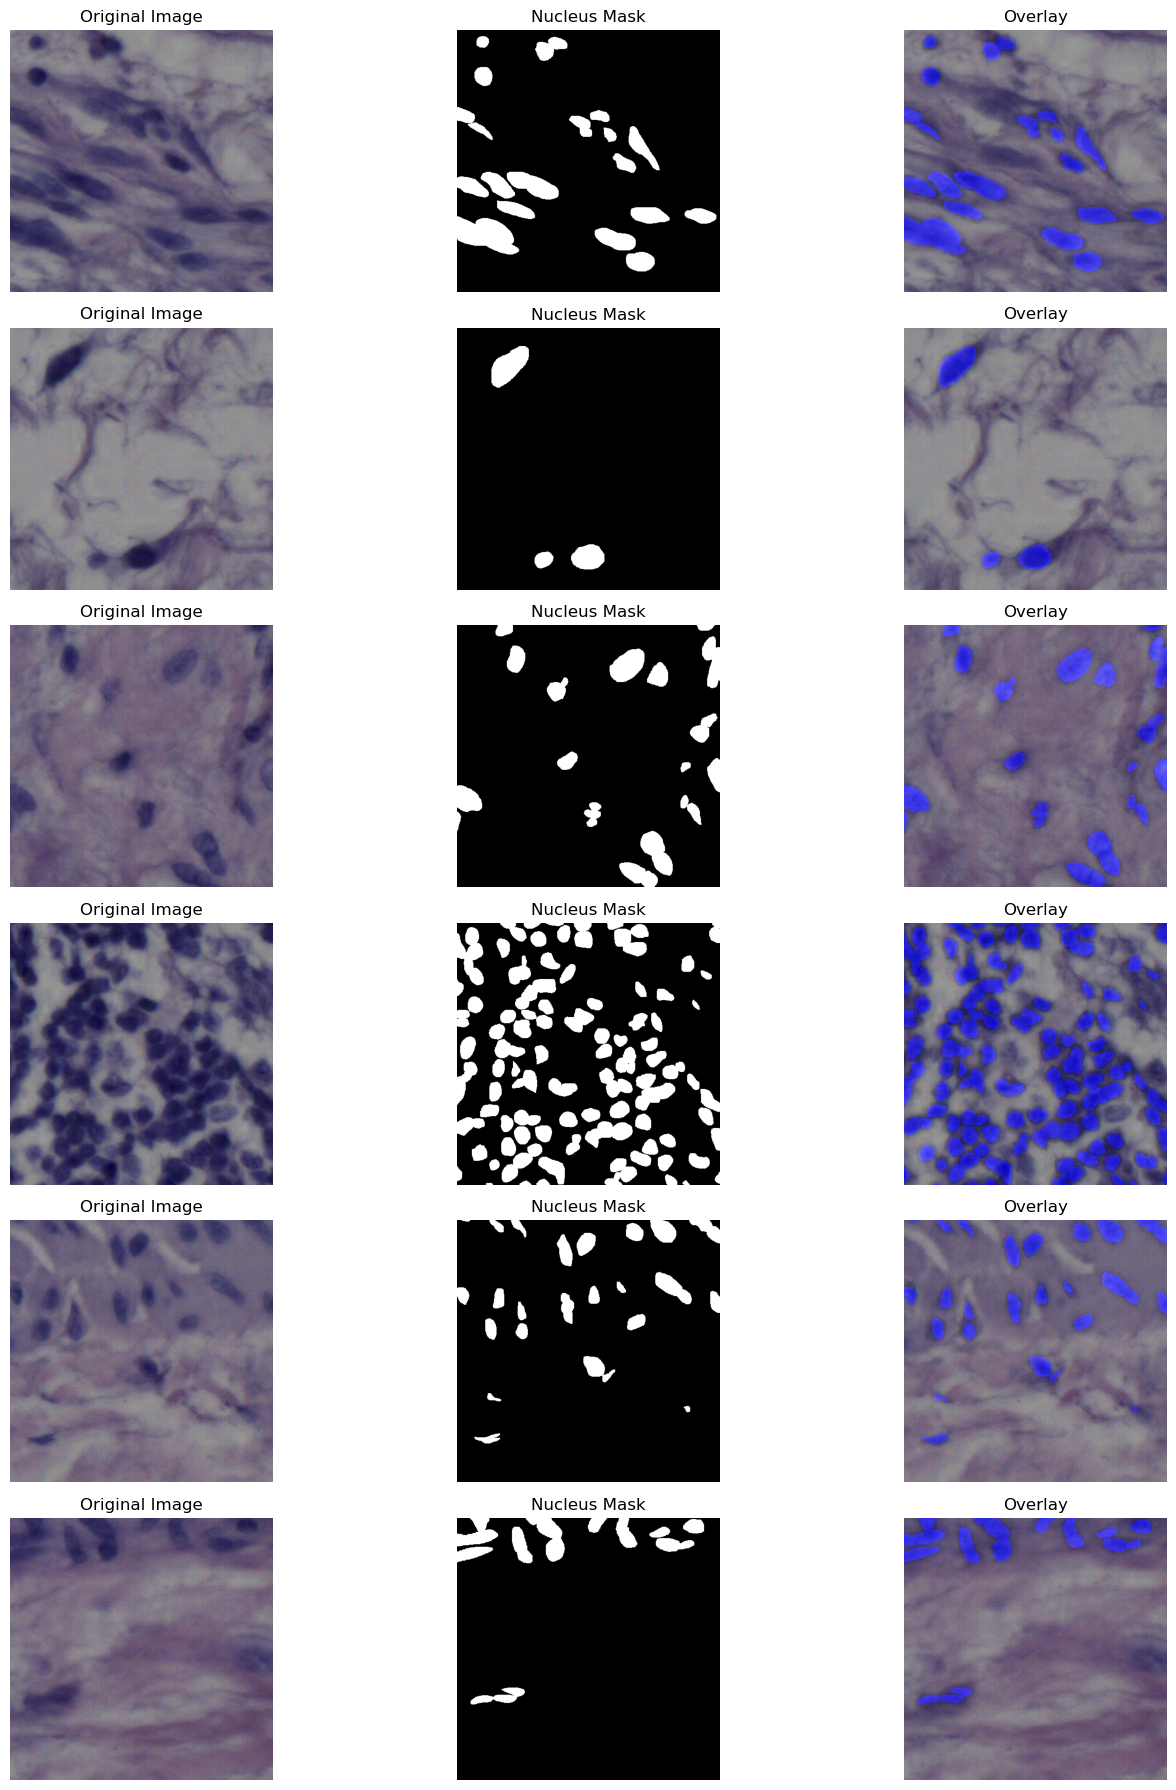

 Preprocessing complete
X shape: (12, 256, 256, 3)
Y shape: (12, 256, 256, 1)


In [2]:
# ================================
#  CONFIGURATION
# ================================

# Set base dataset directory (adjust if needed)
BASE_DIR = "."  # or use full path if notebook is outside the dataset folder
IMAGE_DIR = os.path.join(BASE_DIR, "tissue images")
MASK_DIR = os.path.join(BASE_DIR, "mask binary")  # or "label masks"

# Image size for model input
TARGET_SIZE = (256, 256)

# ================================
#  PREPROCESSING FUNCTIONS
# ================================

def preprocess_image(image, target_size):
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

def preprocess_mask(mask, target_size):
    mask = cv2.resize(mask, target_size)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    mask = mask.astype(np.float32) / 255.0
    mask = np.expand_dims(mask, axis=-1)  # Shape: (H, W, 1)
    return mask

# ================================
#  LOAD, DISPLAY, AND PREPROCESS
# ================================

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

X = []  # Preprocessed images
Y = []  # Preprocessed masks

num_samples = min(6, len(image_files))  # For visualization
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

for i in range(len(image_files)):
    img_path = os.path.join(IMAGE_DIR, image_files[i])
    mask_path = os.path.join(MASK_DIR, mask_files[i])

    #  Load original image and grayscale mask
    image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #  Convert to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    #  Display-only section
    if i < num_samples:
        overlay = image_rgb.copy()
        color_mask = np.zeros_like(image_rgb)
        color_mask[:, :, 2] = mask_gray  # red channel
        overlay = cv2.addWeighted(image_rgb, 1, color_mask, 0.5, 0)

        axes[i, 0].imshow(image_rgb)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_gray, cmap="gray")
        axes[i, 1].set_title("Nucleus Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")

    #  Preprocess and store for training
    image = preprocess_image(image_rgb, TARGET_SIZE)
    mask = preprocess_mask(mask_gray, TARGET_SIZE)

    X.append(image)
    Y.append(mask)

plt.tight_layout()
plt.show()

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

print(" Preprocessing complete")
print("X shape:", X.shape)
print("Y shape:", Y.shape)


In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm


In [21]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


In [22]:
class HistopathologySRDataset(Dataset):
    def __init__(self, image_dir, transform_hr, transform_lr):
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')]
        self.transform_hr = transform_hr
        self.transform_lr = transform_lr

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = Image.open(img_path).convert('RGB')
        hr = self.transform_hr(img)
        lr = self.transform_lr(img)
        return lr, hr


In [23]:
transform_hr = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

transform_lr = transforms.Compose([
    transforms.Resize((85, 85)),  # x3 downscale
    transforms.Resize((256, 256)),  # back upsample
    transforms.ToTensor()
])


In [24]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, device, save_path="model_epoch"):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for lr, hr in tqdm(dataloader):
            lr, hr = lr.to(device), hr.to(device)

            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # 🔥 Tam temizleme
            del sr, loss, lr, hr
            torch.cuda.empty_cache()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")



In [25]:
def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = HistopathologySRDataset(image_dir='all tissue img', transform_hr=transform_hr, transform_lr=transform_lr)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = SRCNN().to(device)
criterion = nn.L1Loss()  # replace MSELoss

optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_model(model, dataloader, criterion, optimizer, num_epochs=50, device=device)



100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:28<00:00,  2.99it/s]


Epoch 1/50, Loss: 0.0858


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:26<00:00,  3.14it/s]


Epoch 2/50, Loss: 0.0204


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:27<00:00,  3.07it/s]


Epoch 3/50, Loss: 0.0139


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:28<00:00,  2.98it/s]


Epoch 4/50, Loss: 0.0123


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:28<00:00,  2.94it/s]


Epoch 5/50, Loss: 0.0114


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.90it/s]


Epoch 6/50, Loss: 0.0113


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:28<00:00,  2.94it/s]


Epoch 7/50, Loss: 0.0107


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:28<00:00,  2.93it/s]


Epoch 8/50, Loss: 0.0107


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.83it/s]


Epoch 9/50, Loss: 0.0104


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:32<00:00,  2.62it/s]


Epoch 10/50, Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:31<00:00,  2.69it/s]


Epoch 11/50, Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:33<00:00,  2.54it/s]


Epoch 12/50, Loss: 0.0102


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:32<00:00,  2.56it/s]


Epoch 13/50, Loss: 0.0106


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.88it/s]


Epoch 14/50, Loss: 0.0101


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.85it/s]


Epoch 15/50, Loss: 0.0097


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.84it/s]


Epoch 16/50, Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.78it/s]


Epoch 17/50, Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.81it/s]


Epoch 18/50, Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.82it/s]


Epoch 19/50, Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.83it/s]


Epoch 20/50, Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:32<00:00,  2.62it/s]


Epoch 21/50, Loss: 0.0094


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.75it/s]


Epoch 22/50, Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.79it/s]


Epoch 23/50, Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.83it/s]


Epoch 24/50, Loss: 0.0092


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.74it/s]


Epoch 25/50, Loss: 0.0096


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.78it/s]


Epoch 26/50, Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.82it/s]


Epoch 27/50, Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.79it/s]


Epoch 28/50, Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.77it/s]


Epoch 29/50, Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.79it/s]


Epoch 30/50, Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.84it/s]


Epoch 31/50, Loss: 0.0095


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.85it/s]


Epoch 32/50, Loss: 0.0089


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.79it/s]


Epoch 33/50, Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.82it/s]


Epoch 34/50, Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.88it/s]


Epoch 35/50, Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.89it/s]


Epoch 36/50, Loss: 0.0091


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.84it/s]


Epoch 37/50, Loss: 0.0090


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.78it/s]


Epoch 38/50, Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:28<00:00,  2.90it/s]


Epoch 39/50, Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.88it/s]


Epoch 40/50, Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.85it/s]


Epoch 41/50, Loss: 0.0087


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.81it/s]


Epoch 42/50, Loss: 0.0088


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.84it/s]


Epoch 43/50, Loss: 0.0093


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.77it/s]


Epoch 44/50, Loss: 0.0085


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:30<00:00,  2.75it/s]


Epoch 45/50, Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.84it/s]


Epoch 46/50, Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.83it/s]


Epoch 47/50, Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:29<00:00,  2.81it/s]


Epoch 48/50, Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:33<00:00,  2.54it/s]


Epoch 49/50, Loss: 0.0086


100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:31<00:00,  2.67it/s]

Epoch 50/50, Loss: 0.0091


In [27]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def show_sr_results(model, dataset, device, index=0):
    model.eval()
    with torch.no_grad():
        # Verisetinden bir örnek al
        lr, hr = dataset[index]
        lr = lr.unsqueeze(0).to(device)
        sr = model(lr).cpu().squeeze(0)

        # Tensorları görüntüye çevir
        lr_img = TF.to_pil_image(lr.squeeze(0).cpu())
        hr_img = TF.to_pil_image(hr.cpu())
        sr_img = TF.to_pil_image(torch.clamp(sr, 0, 1))  # clamp önemli!

        # Görüntüleri yan yana göster
        plt.figure(figsize=(12,4))
        plt.subplot(1, 3, 1)
        plt.title("Low-Res (Upsampled)")
        plt.imshow(lr_img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Super-Res (SRCNN Output)")
        plt.imshow(sr_img)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("High-Res (Ground Truth)")
        plt.imshow(hr_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        plt.close()  # RAM’i temizle


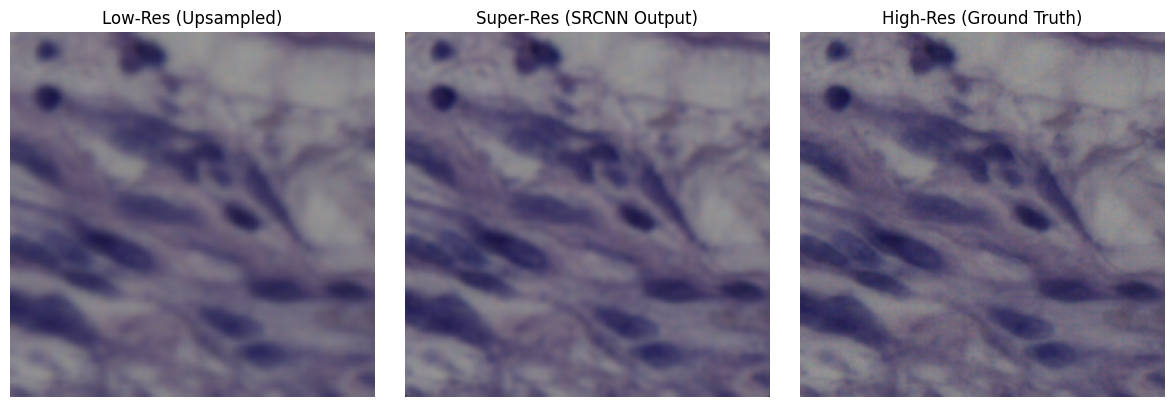

In [28]:
show_sr_results(model, dataset, device, index=0)


In [29]:
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

def evaluate_sr_quality(model, dataset, device, index=0):
    """
    Verilen model ve dataset ile belirtilen index'teki görüntü için
    PSNR ve SSIM değerlerini hesaplar ve görüntüleri gösterir.
    """
    model.eval()  # Modeli değerlendirme moduna al
    with torch.no_grad():
        # Dataset'ten LR ve HR görüntüyü al
        lr, hr = dataset[index]
        lr = lr.unsqueeze(0).to(device)     # Model inputu için batch dimension ekle
        hr = hr.unsqueeze(0).to(device)

        # Modelden süper çözünürlük çıktısını al
        sr = model(lr).clamp(0.0, 1.0)      # Çıktıyı 0–1 arasına kırp

        # PSNR hesapla (pytorch → numpy çevirip kullanıyoruz)
        sr_np = sr.squeeze().cpu().permute(1, 2, 0).numpy()  # CxHxW → HxWxC
        hr_np = hr.squeeze().cpu().permute(1, 2, 0).numpy()

        psnr = peak_signal_noise_ratio(hr_np, sr_np, data_range=1.0)

        # SSIM hesapla (renkli olduğu için multichannel=True)
        ssim = structural_similarity(hr_np, sr_np, data_range=1.0, channel_axis=2)

        # Sonuçları yazdır
        print(f" PSNR: {psnr:.2f} dB")
        print(f" SSIM: {ssim:.4f}")

        # Karşılaştırmalı görsel göster
        import matplotlib.pyplot as plt
        import torchvision.transforms.functional as TF

        lr_img = TF.to_pil_image(lr.squeeze(0).cpu())
        hr_img = TF.to_pil_image(hr.squeeze(0).cpu())
        sr_img = TF.to_pil_image(sr.squeeze(0).cpu())

        plt.figure(figsize=(12,4))
        plt.subplot(1, 3, 1)
        plt.title("Low-Res (Upsampled)")
        plt.imshow(lr_img)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title(f"Super-Res\nPSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")
        plt.imshow(sr_img)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("High-Res (Ground Truth)")
        plt.imshow(hr_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        plt.close()  # RAM’i temizle


 PSNR: 38.14 dB
 SSIM: 0.9250


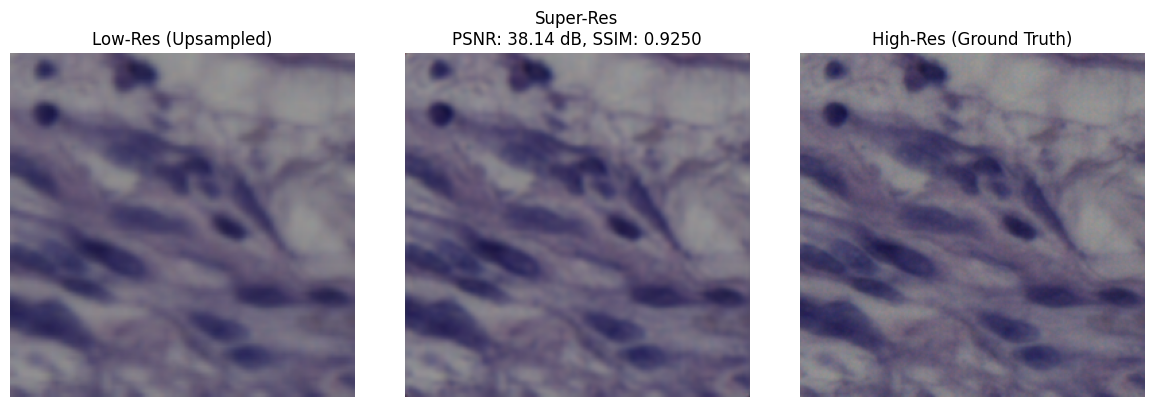

In [30]:
evaluate_sr_quality(model, dataset, device, index=0)


 PSNR: 38.43 dB
 SSIM: 0.9088


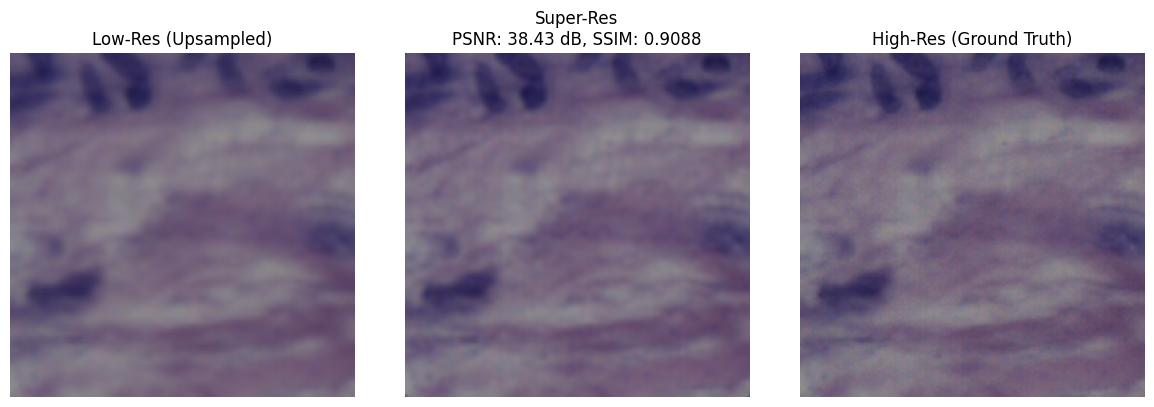

 PSNR: 38.36 dB
 SSIM: 0.8999


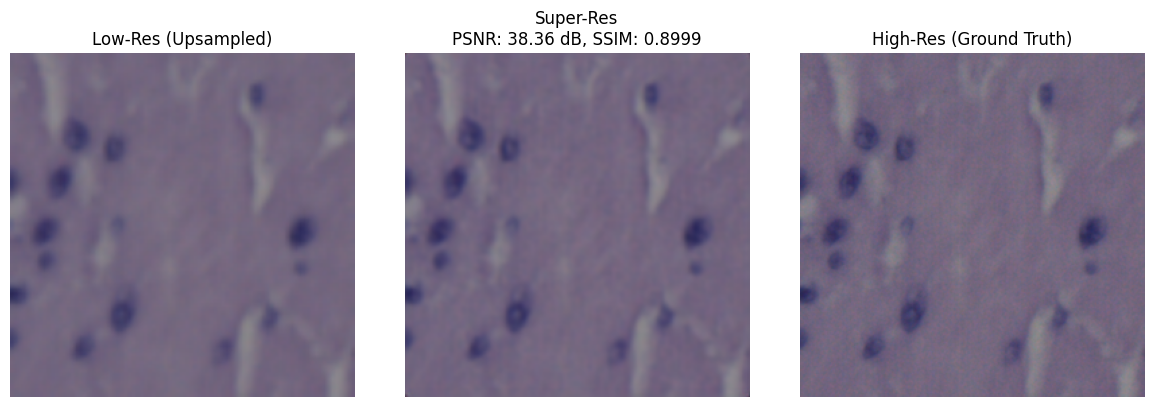

In [31]:
evaluate_sr_quality(model, dataset, device, index=5)
evaluate_sr_quality(model, dataset, device, index=11)
